导入库

In [ ]:
from selenium import webdriver
from selenium.webdriver import ActionChains
import time
from decimal import Decimal
import pickle
import numpy as np
import pandas as pd

建立浏览器

In [ ]:
browser = webdriver.Chrome()
browser.get('https://www.zhixue.com/')

打开浏览器后登录智学网，进入成绩报告界面

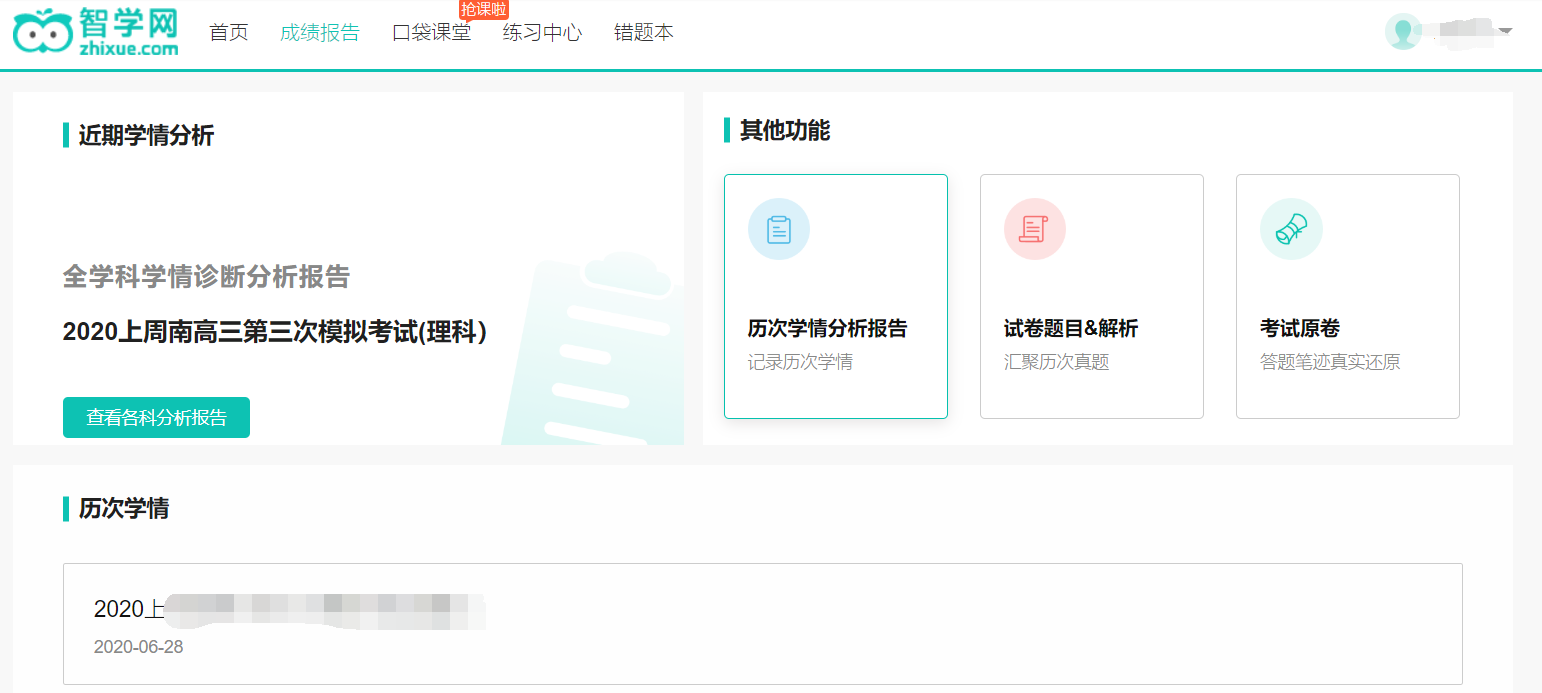

点击历次学情中第一个考试的文字，进入考试报告界面

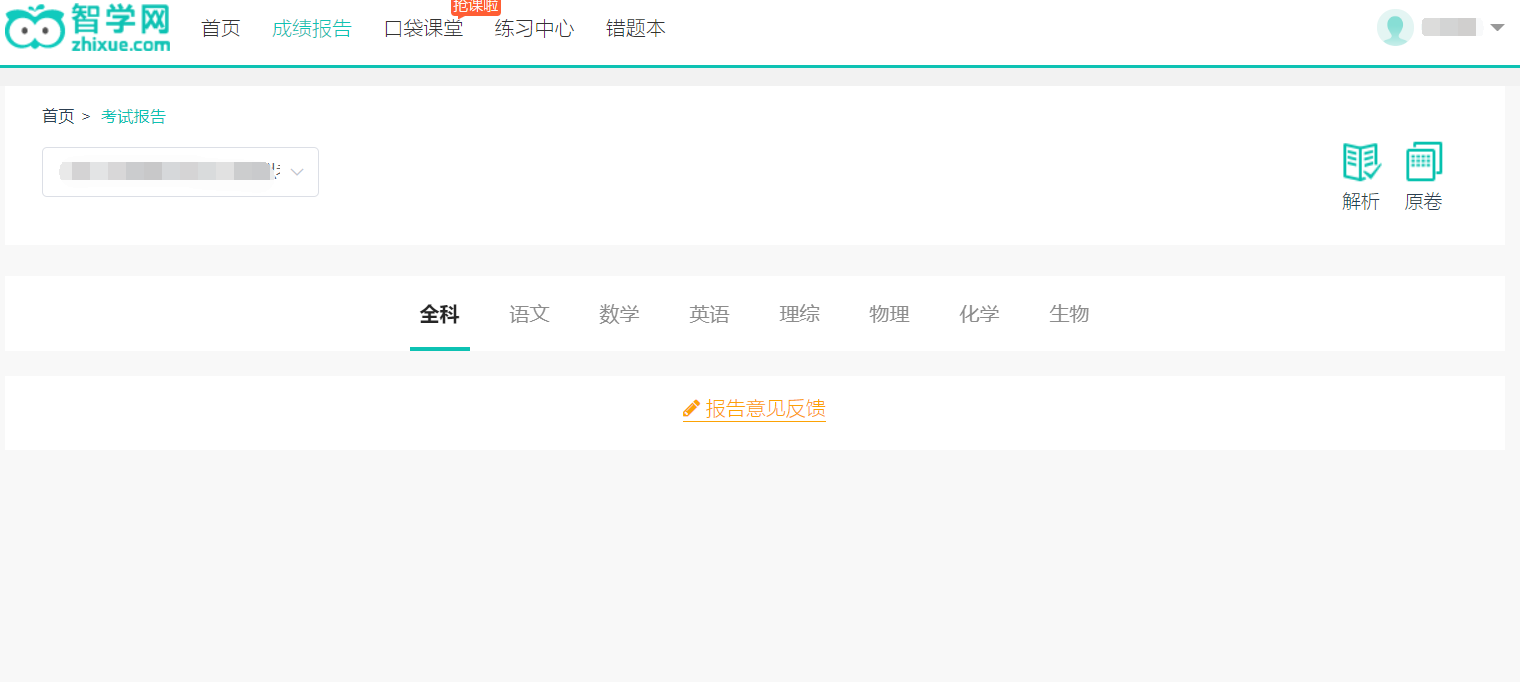

执行以下代码，time.sleep()的延迟值可根据本地网络状况进行调整

lz本地电信100M网络

输出解释：

第一行整数为爬到的考试总数

之后的n+1行是将从新到旧的考试中智学网给出的学科顺序的学科成绩，可实时对照浏览器上显示的成绩检查程序是否录入正确

建议将程序控制的浏览器窗口最大化，以保证程序的模拟点击正常

In [ ]:
w = []
i = 0
count = 999999
def openInner(limit):
    action = ActionChains(browser)
    browser.find_element_by_class_name("el-input__inner").click()
    time.sleep(0.8)
    while True:
        bs = browser.find_elements_by_class_name("el-select-dropdown__item")
        if len(bs)>limit:
            return bs
        try:
            a = browser.find_element_by_class_name("load-more")
        except:
            return bs
        else:
            a.location_once_scrolled_into_view
            a.click()
            time.sleep(1)

count=len(openInner(10000000000))
print(count)
browser.refresh()

while i<count:
    time.sleep(2)
    Nexam = {}
    a = openInner(i)[i]
    Nexam['name']=a.text
    a.location_once_scrolled_into_view
    a.click()
    time.sleep(2)
    
    bs = browser.find_elements_by_class_name("other-module")
    b = {b.text:b for b in bs}['原卷']
    b.click()
    
    time.sleep(2)
    cs = browser.find_elements_by_class_name("zx-tab-item-label")
    for c in cs:
        if c.text!="理综" and c.text!="文综":
            c.click()
            time.sleep(1.5)
            imgs = browser.find_elements_by_class_name("answer-card-img")
            if len(imgs)>0:
                Nexam[c.text+"imageURL"]=[a.get_attribute("src") for a in imgs]
                Nexam[c.text]=Decimal(browser.find_element_by_class_name("total-score-text").text)
                print(Nexam[c.text])
    browser.back()
    w.append(Nexam)
    i=i+1

请在正确执行完上面的代码之后调用，可额外获得每场考试的时间以及修复之前未能获取到的考试名称。

In [ ]:
browser.get("https://www.zhixue.com/activitystudy/web-report/index.html?from=web-container_top#/")
def openInner2():
    while True:
        a = browser.find_element_by_class_name("show-more-view")
        if a.get_attribute("style")=="display: none;":
            break
        a.location_once_scrolled_into_view
        a.click()
        time.sleep(1)
openInner2()
names = browser.find_elements_by_class_name("text-exam-name")
dates = browser.find_elements_by_class_name("text-exam-date")

ps = [(name.text,date.text) for name,date in zip(names,dates)]

for i,p in enumerate(ps):
    if w[i]['name']==p[0] or w[i]['name']=="":
        w[i]['date']=p[1]
        w[i]['name']=p[0]

简单的统计高中各年级考试数量

In [ ]:
g1,g2,g3 = 0,0,0
o=0
for i in w:
    o+=1
    g1 += 0 if i["name"].find("高一")==-1 else 1
    g2 += 0 if i["name"].find("高二")==-1 else 1
    g3 += 0 if i["name"].find("高三")==-1 else 1
    if i["name"].find("高一")==-1 and i["name"].find("高二")==-1 and i["name"].find("高三")==-1:
        print(i["name"]+i["date"]+",序号:"+str(o))
print(str("高一:")+str(g1))
print(str("高二:")+str(g2))
print(str("高三:")+str(g3))
print(g1+g2+g3)

调用pickle持久化爬到的数据

In [ ]:
pickle.dump(w,open("dict2","wb"))

调用pickle恢复数据

In [ ]:
w = pickle.load(open("dict2","rb"))

导出到excel

In [ ]:
columns = ['考试名称','考试日期','语文','数学','英语','物理','化学','生物','政治','历史','地理']
Data = pd.DataFrame(([tuple([i['name'],i['date']]+[str(i.get(j,-1)) for j in columns[2:]]) for i in w]),columns = columns)
Data.to_excel('dict.xlsx')